# TP3 : WEEEU WEEEU, ceci est une descente de police !

Aujourd'hui, nouveau cas concret de l'utilisation de la vision par ordinateur : la reconnaissance d'empreintes. Le commissariat de police du 99ème district de Brooklyn a besoin de votre aide sur une nouvelle scène de crime. Les experts ont pu prélever plusieurs empreintes sur divers objets, et vous avez pour objectif de retrouver l'identité des coupables.

Pour cela, vous avez à votre disposition les empreintes à analyser prise sur la scène de crime (dossier Images_suspects), ainsi qu'une base de données d'empreintes du FBI (dossier DB_FBI). A vous de jouer !

---


## 1) C'est pas un bug, c'est une feature

Dans un premier temps, vous allez écrire le code pour détecter les minutiaes des empreintes de doigt. Les minutiae sont des caractéristiques spécifiques d'une empreinte qui permettent ensuite d'identifier l'individu.

Pour ce TP, vous détecterez 2 types de miniutiaes : 
- Les terminaisons (a) 
- Les bifurcations (b)

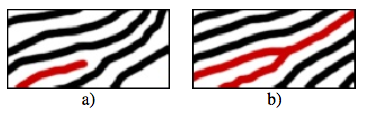

Pour cela, plusieurs étapes sont nécessaires, mais on va faire ça ensemble. Vous allez traiter dans un premier temps les images de la base de données *DB_FBI*, où les images ont déjà été traitées et binarisées en amont.

a) Commençons avec la base de la base : chargez les libraries nécessaires pour ce TP, puis les images de la base de données DB_FBI. Affichez ensuite quelques images de cette base.

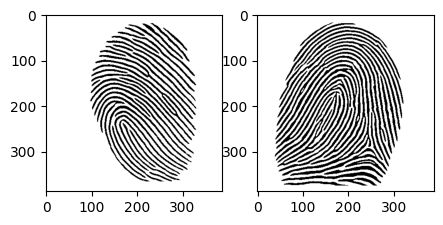

In [1]:
# A compléter
# Chargement des librairies
import cv2
from matplotlib import pyplot as plt
import numpy as np
import os
import skimage

# Chargement des images de la base de données
path = 'DB_FBI/'
images = [cv2.imread(path+f,0) for f in os.listdir(path)]

# Affichage des quelques images de la base de données
plt.figure(figsize=(5,10))
plt.subplot(121)
plt.imshow(images[0],'gray')
plt.subplot(122)
plt.imshow(images[1],'gray')
plt.show()

b) La première étape est la skeletization, une opération de morphologie mathématique.

***En quoi consiste la skeletization ?***

***Réponse :***

***Pourquoi est-il intéressant dans notre contexte de faire une skeletization :***

***Réponse :***

L'opération étant un peu complexe à implémenter, on va utiliser une version déjà implémentée proposée par scikit-image. La fonction se nomme *thin*.

Prenez une image exemple de la base de données, appliquez une skeletization et affichez le résultat obtenu.

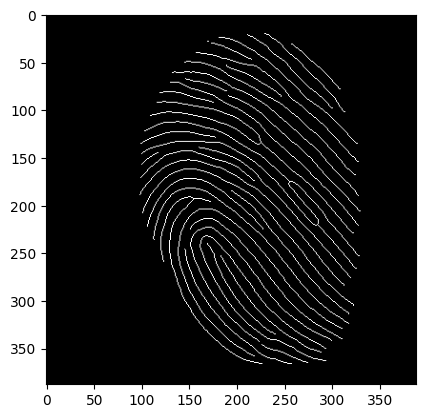

In [2]:
# A compléter
# Skeletization de l'image
image_example = images[0]
skel_img = skimage.morphology.thin(~image_example)

# Affichage du résultat
plt.figure()
plt.imshow(skel_img,'gray')
plt.show()

***Le résultat vous paraît-t-il satisfaisant ? Pour cela, comparez le résultat avec votre image originale.***

***Réponse :***

c) C'est parti pour la détection ! Occupons-nous d'abord des terminaisons.

D'un point de vue local, un pixel est considéré comme une terminaison si et seulement si :
- Le pixel est blanc
- Un seul pixel dans son entourage (fenêtre 3x3) est blanc

Implémentez une fonction permettant de détecter les terminaisons (sous forme d'une matrice de taille Nx2 avec N le nombre de terminaisons et 2 les coordonnées dans l'image). Appliquez ensuite votre fonction sur votre image skeletizée.

In [3]:
# A compléter
# Fonction de détection des terminaisons
def detect_terminaisons(img):
    h,w = img.shape
    output = np.zeros(img.shape)
    for i in range(h):
        for j in range(w):
            fenetre = img[max(i-1,0):min(i+2,h),max(j-1,0):min(j+2,w)]
            if np.logical_and(img[i,j],fenetre.sum()==2):
                output[i,j]=255
            else:
                output[i,j]=0
    term = np.argwhere(output==255)
    return term
# Application de la fonction de détection de terminaisons
terminaisons = detect_terminaisons(skel_img)

Il faut visualiser tout ça ! Pour cela, implémentez une fonction d'affichage prenant en entrée votre image d'origine et les terminaisons détectées. Votre fonction affichera l'image avec les terminaisons (en petits cercles rouge).

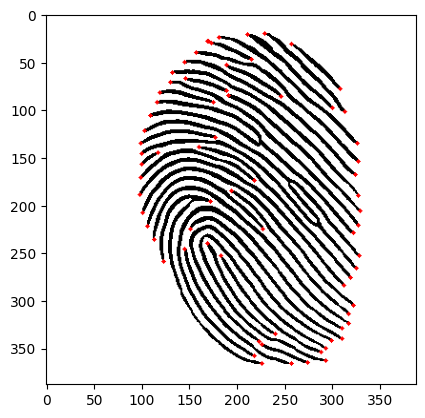

In [4]:
# A compléter
# Fonction d'affichage des terminaisons sur l'image d'origine
def plot_terminaisons(img,terms):
    output = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    for t in terms:
        cv2.circle(output,(t[1],t[0]),2,(255,0,0),-1)
    plt.figure()
    plt.imshow(output)
    plt.show()

# Application de la fonction d'affichage sur votre image exemple
plot_terminaisons(image_example,terminaisons)

***Les terminaisons détectées sont-elles correctes ?***

***Réponse :***

d) La fonction de détection des terminaisons fonctionne en l'état, mais ce sera beaucoup plus difficile pour les bifurcations. Pour palier à ce problème, on va utiliser une autre fonction connue de morphologie mathématique : Hit or Miss. Cette fonction permet de trouver des patterns particuliers sur une image. Pour cela, il faut définir un kernel défini de la manière suivante :
- Les valeurs du kernel à 1 doivent être blancs sur l'image
- Les valeurs du kernel à -1 doivent être noirs sur l'image
- Les valeurs du kernel à 0 peuvent être noirs ou blancs sur l'image

En appliquant ce kernel sur votre image, tous les pixels blancs seront ceux respectant les règles définies par le kernel. Les autres seront noirs.

Heureusement, OpenCV propose la fonction Hit Or Miss : https://docs.opencv.org/4.x/db/d06/tutorial_hitOrMiss.html

***En utilisant des kernels de taille 3x3, combien de kernels aura-ton besoin pour détecter tous les types de terminaisons ?***

***Réponse :***

Définissez les kernels qui seront utilisés pour la détection de terminaisons

*Note : Histoire de gagner du temps et de la lisibilité dans le code, vous pouvez utiliser la fonction rotate d'OpenCV, permettant de faire des rotations à 90°, 180° ou 270°*

In [5]:
# A compléter
# Définition des kernels pour détecter les types de terminaisons
kernel_1 = np.array([[-1,-1,-1],
                     [-1,1,1],
                     [-1,-1,-1]])

kernel_2 = np.array([[-1,-1,-1],
                     [-1,1,-1],
                     [-1,-1,1]])

from itertools import product

kernels_terminaisons = [cv2.rotate(kernel,angle) if angle!= -1 else kernel for kernel,angle in product([kernel_1,kernel_2],[-1,0,1,2])]

Appliquez maintenant la morphologie mathématique Hit Or Miss d'OpenCV sur votre image skeletizée avec vos kernels. Récupérez ensuite les coordonnées des pixels blancs des images résultats, ce qui constituera votre matrice de terminaisons. Affichez ensuite ces terminaisons sur votre image d'origine et comparez les résultats par rapport à votre fonction de détection implémentée dans la partie b)

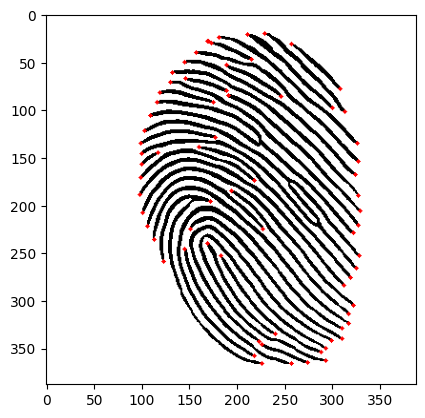

In [6]:
# A compléter
# Hit Or Miss sur l'image skeletizée avec les kernels de terminaisons
masks_terms = [cv2.morphologyEx((skel_img*255).astype(np.uint8),cv2.MORPH_HITMISS,kernel) for kernel in kernels_terminaisons]
mask_terms = np.sum(np.stack(masks_terms,0),0)>0

# Récupération des terminaisons détectées
terminaisons = np.argwhere(mask_terms)

# Affichage des terminaisons sur l'image d'origine
plot_terminaisons(image_example,terminaisons)

***Le résultat obtenu est-il le même que celui obtenu avec votre précédente fonction de détection ?***

***Réponse :***

e) Passons aux bifurcations. Même principe que précédemment avec Hit Or Miss.

***Combien de kernels aura-ton besoin pour détecter tous les types de bifurcations ?***

***Réponse :***

Définissez les kernels qui seront utilisés pour la détection de bifurcations

In [7]:
# A compléter
# Définition des kernels pour détecter les types de bifurcations
kernel_1 = np.array([[ 1,-1,-1],
                     [-1, 1, 1],
                     [-1, 1,-1]])

kernel_2 = np.array([[-1,-1, 1],
                     [ 1, 1,-1],
                     [-1,-1, 1]])

kernel_3 = np.array([[ 1,-1, 1],
                     [-1, 1,-1],
                     [-1,-1, 1]])

kernel_4 = np.array([[-1, 1,-1],
                     [ 1, 1, 1],
                     [-1,-1,-1]])

kernels_bifurcations = [cv2.rotate(kernel,angle) if angle!= -1 else kernel for kernel,angle in product([kernel_1,kernel_2,kernel_3,kernel_4],[-1,0,1,2])]

Appliquez Hit Or Miss sur votre image skeletizée avec vos kernels. Récupérez ensuite les coordonnées des bifurcations. Affichez ensuite ces bifurcations sur votre image d'origine. Pour cela, modifiez votre fonction d'affichage pour afficher les terminaisons en rouge et les bifurcations en vert.

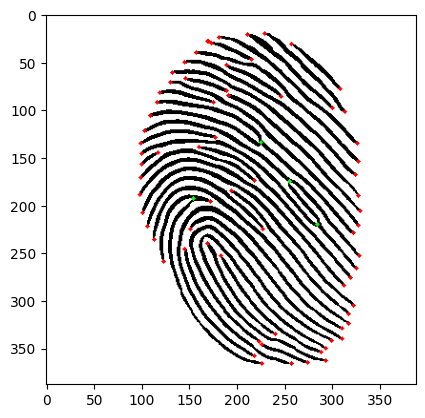

In [8]:
# A compléter
# Hit Or Miss sur l'image skeletizée avec les kernels de bifurcations
masks_bifs = [cv2.morphologyEx((skel_img*255).astype(np.uint8),cv2.MORPH_HITMISS,kernel) for kernel in kernels_bifurcations]
mask_bifs = np.sum(np.stack(masks_bifs,0),0)>0

# Récupération des bifurcations détectées
bifurcations = np.argwhere(mask_bifs)

# Modification de la fonction d'affichage pour afficher différement les terminaisons (rouge) des bifurcations (verts)
def plot_minutiaes(img,terms,bifs):
    output = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    for t in terms:
        cv2.circle(output,(t[1],t[0]),2,(255,0,0),-1)
    for b in bifs:
        cv2.circle(output,(b[1],b[0]),2,(0,255,0),-1)
    plt.figure()
    plt.imshow(output)
    plt.show()

# Affichage des terminaisons et des bifurcations sur l'image d'origine
plot_minutiaes(image_example,terminaisons,bifurcations)

***Le résultat est-il satisfaisant ?***

***Réponse :***

Regroupez le code écrit précédemment pour implémenter une seule fonction qui détecte les terminaisons et bifurcations d'une image skeletizée. 

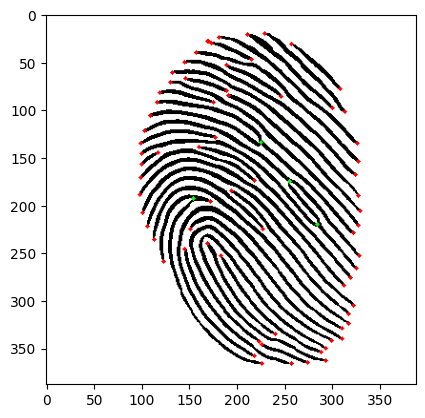

In [9]:
# A compléter
# Fonction de détection des terminaisons et bifurcations
def detect_minutiaes(img):
    kernel_1 = np.array([[-1,-1,-1],
                        [-1,1,1],
                         [-1,-1,-1]])

    kernel_2 = np.array([[-1,-1,-1],
                        [-1,1,-1],
                        [-1,-1,1]])
    kernels_terminaisons = [cv2.rotate(kernel,angle) if angle!= -1 else kernel for kernel,angle in product([kernel_1,kernel_2],[-1,0,1,2])]
    
    kernel_1 = np.array([[ 1,-1,-1],
                     [-1, 1, 1],
                     [-1, 1,-1]])

    kernel_2 = np.array([[-1,-1, 1],
                        [ 1, 1,-1],
                        [-1,-1, 1]])

    kernel_3 = np.array([[ 1,-1, 1],
                        [-1, 1,-1],
                        [-1,-1, 1]])

    kernel_4 = np.array([[-1, 1,-1],
                        [ 1, 1, 1],
                        [-1,-1,-1]])
    
    kernels_bifurcations = [cv2.rotate(kernel,angle) if angle!= -1 else kernel for kernel,angle in product([kernel_1,kernel_2,kernel_3,kernel_4],[-1,0,1,2])]

    masks_terms = [cv2.morphologyEx((skel_img*255).astype(np.uint8),cv2.MORPH_HITMISS,kernel) for kernel in kernels_terminaisons]
    mask_terms = np.sum(np.stack(masks_terms,0),0)>0

    terminaisons = np.argwhere(mask_terms)

    masks_bifs = [cv2.morphologyEx((skel_img*255).astype(np.uint8),cv2.MORPH_HITMISS,kernel) for kernel in kernels_bifurcations]
    mask_bifs = np.sum(np.stack(masks_bifs,0),0)>0

    bifurcations = np.argwhere(mask_bifs)

    return terminaisons, bifurcations
    
# Application sur votre image skeletizée
terms, bifs = detect_minutiaes(skel_img)

# Affichage des résultats
plot_minutiaes(image_example,terms,bifs)

f) Afin de mieux décrire les terminaisons et bifurcations détectées, vous allez ajouter aux informations de localisation (coordonnées cartésiennes), des informations d'orientation. Une terminaison a une seule orientation alors qu'une bifurcation en a trois. Dès lors, les terminaisons T et bifurcation B auront la forme suivante :

- $T_{i} = \{x_{i},y_{i},\theta_{i}\}$
- $B_{i} = \{x_{i},y_{i},\theta^{1}_{i},\theta^{2}_{i},\theta^{3}_{i}\}$

Pour définir les orientations, on caractérisera $\theta$ sous forme d'angle en radians en fonction du cercle trigonométrique

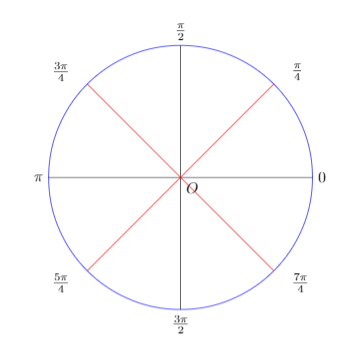

Modifiez votre fonction de détection des terminaisons et bifurcations afin de calculer leurs orientations. Les matrices de terminaisons et bifurcations seont respectivement de taille Nx3 et Mx5 avec N et M les nombres de terminaisons et bifurcations trouvées. Appliquez votre fonction sur votre image skeletizée.

*Note : Pour la suite du TP, il faut que les orientations des bifurcations soient triées dans l'ordre croissant*

In [10]:
# A compléter
# Fonction de détection des terminaisons et bifurcations et calcul de leur orientation
def orientation_minutiae(skel_img, terms, bifs):
    """
        Calcule les orientations des terminaisons et bifurcations d'une empreinte.
        
        Arguments:
            skel_img : l'image skeletizée de l'empreinte
            terms (nd.array Nx2): les coordonnées des terminaisons détectées de l'empreinte
            bifs (nd.array Mx3): les coordonnées des terminaisons détectées de l'empreinte
        
        Retourne :
            terms (nd.array N'x3): les coordonnées et l'orientation des terminaisons détectées de l'empreinte
            bifs (nd.array M'x5): les coordonnées et les trois orientations des bifurcations détectées de l'empreinte
    """
    h_b,_ = bifs.shape
    h_t,_ = terms.shape
    h_I,w_I = skel_img.shape
    
    bifs_x = bifs[:,0]
    bifs_y = bifs[:,1]
    terms_x = terms[:,0]
    terms_y = terms[:,1]
    
    # Initialisation des matrices des orientations des minutiaes
    orient_terms = np.ones(terms_x.shape)*-10
    orient_bifs = np.ones((len(bifs_x),3))*-10

    # Définition des angles d'orientations dans la fenêtre 3x3
    table = np.array([[3*np.pi/4,np.pi/2,np.pi/4],
                      [np.pi,0,0],
                      [5*np.pi/4,3*np.pi/2,7*np.pi/4]])

    # Calcul des orientations des terminaisons
    for i in range(h_t):
        if (1<terms_x[i]<h_I-2) & (1<terms_y[i]<w_I-2):
            # Sélection de la fenêtre 3x3 centrée sur la terminaison
            K_local = skel_img[terms_x[i]-1:terms_x[i]+2,terms_y[i]-1:terms_y[i]+2].copy()
            # Mise à zéro du centre dans la fenêtre
            K_local[1,1] = 0
            # Récupération des coordonnées du pixel blanc dans la fenêtre
            arg_k = np.argwhere(K_local)
            # Calcul de l'angle de la terminaison à partir de ses coordonnées
            orient_terms[i] = table[arg_k[0,0],arg_k[0,1]]
    
    # Calcul des orientations des bifurcations
    for i in range(h_b):
        if (1<bifs_x[i]<h_I-2) & (1<bifs_y[i]<w_I-2):
            # Sélection de la fenêtre 3x3 centrée sur la bifurcation
            K_local = skel_img[bifs_x[i]-1:bifs_x[i]+2,bifs_y[i]-1:bifs_y[i]+2].copy()
            # Mise à zéro du centre dans la fenêtre
            K_local[1,1] = 0
            # Récupération des coordonnées du pixel blanc dans la fenêtre
            arg_k = np.argwhere(K_local)
            #if K_local.sum()==3:
            # Calcul des angles de la bifurcations à partir des coordonnées
            orient_bifs[i]=np.sort([table[arg_k[j,0],arg_k[j,1]] for j in range(3)])
                
    # Suppression des minutiaes invalides
    ind_keep_bifs = orient_bifs[:,0]!=-10
    orient_bifs = orient_bifs[ind_keep_bifs]
    bifs = bifs[ind_keep_bifs]
    
    ind_keep_terms = orient_terms!=-10
    orient_terms = orient_terms[ind_keep_terms]
    terms = terms[ind_keep_terms]

    # Concatenation des minutiaes avec leur orientation calculée
    terms = np.concatenate([terms,np.expand_dims(orient_terms,-1)],axis=-1)
    bifs = np.concatenate([bifs,orient_bifs],axis=-1)

    return terms, bifs

def detect_minutiaes(img):
    kernel_1 = np.array([[-1,-1,-1],
                        [-1,1,1],
                         [-1,-1,-1]])

    kernel_2 = np.array([[-1,-1,-1],
                        [-1,1,-1],
                        [-1,-1,1]])
    kernels_terminaisons = [cv2.rotate(kernel,angle) if angle!= -1 else kernel for kernel,angle in product([kernel_1,kernel_2],[-1,0,1,2])]
    
    kernel_1 = np.array([[ 1,-1,-1],
                     [-1, 1, 1],
                     [-1, 1,-1]])

    kernel_2 = np.array([[-1,-1, 1],
                        [ 1, 1,-1],
                        [-1,-1, 1]])

    kernel_3 = np.array([[ 1,-1, 1],
                        [-1, 1,-1],
                        [-1,-1, 1]])

    kernel_4 = np.array([[-1, 1,-1],
                        [ 1, 1, 1],
                        [-1,-1,-1]])
    
    kernels_bifurcations = [cv2.rotate(kernel,angle) if angle!= -1 else kernel for kernel,angle in product([kernel_1,kernel_2,kernel_3,kernel_4],[-1,0,1,2])]

    masks_terms = [cv2.morphologyEx((img*255).astype(np.uint8),cv2.MORPH_HITMISS,kernel) for kernel in kernels_terminaisons]
    mask_terms = np.sum(np.stack(masks_terms,0),0)>0

    terminaisons = np.argwhere(mask_terms)

    masks_bifs = [cv2.morphologyEx((img*255).astype(np.uint8),cv2.MORPH_HITMISS,kernel) for kernel in kernels_bifurcations]
    mask_bifs = np.sum(np.stack(masks_bifs,0),0)>0

    bifurcations = np.argwhere(mask_bifs)

    terminaisons, bifurcations = orientation_minutiae(img, terminaisons, bifurcations)

    return terminaisons, bifurcations

# Application sur l'image skeletizée
terms, bifs = detect_minutiaes(skel_img)

Afin de vérifier que votre implémentation est correcte, affichez-moi l'affichage local d'une terminaison et d'une bifurcation (fenêtre 3x3 de l'image centrée sur la minutiae), ainsi que les orientations calculées de ces deux minutiaes

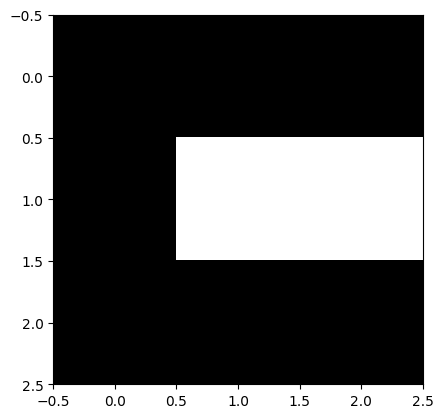

20 229 0.0


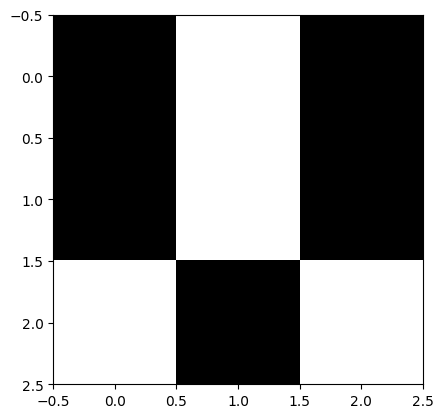

134 225 90.0 225.0 315.0


In [11]:
# A compléter
# Affichage de la fenêtre 3x3 d'une terminaison
x,y,angle = terms[0]
x = int(x)
y = int(y)
plt.figure()
plt.imshow(skel_img[x-1:x+2,y-1:y+2],'gray')
plt.show()
# Affichage de l'orientation de la terminaison
print(x,y,np.rad2deg(angle))

# Affichage de la fenêtre 3x3 d'une bifurcation
x,y,angle1,angle2,angle3 = bifs[0]
x = int(x)
y = int(y)
plt.figure()
plt.imshow(skel_img[x-1:x+2,y-1:y+2],'gray')
plt.show()

# Affichage des orientations de la bifurcation
print(x,y,np.rad2deg(angle1),np.rad2deg(angle2),np.rad2deg(angle3))


g) La fonction de détection est correcte, mais comporte un soucis majeur : beaucoup de minutiaes détectées ne sont pas des caractéristiques de l'empreinte. Elles sont à la limite de l'empreinte, et sont donc liées au champ de capture de l'empreinte. De ce fait, en comparant deux mêmes empreintes mais avec un différent champ de captation, on verra les mêmes minutiaes au centre, mais des minutiaes totalement différentes. Il faut donc supprimer les minutiaes situées en périphérie de l'empreinte

Tout d'abord, effecutez une détection de contours sur l'image originale. Attention : il faut inverser les couleurs en amont (sillures en blanc). Affichez l'image originale avec les contours dessinés en vert

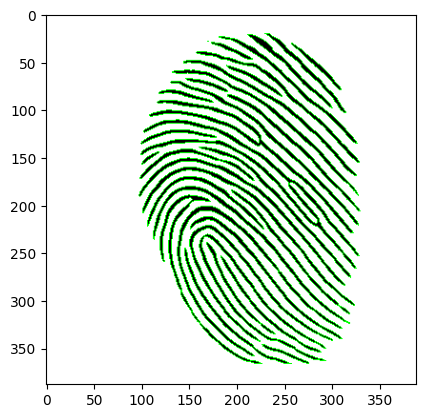

In [12]:
# A compléter
# Détection des contours 
contours,__ = cv2.findContours(~image_example,cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

# Affichage de l'image avec les contours dessinés
output = cv2.cvtColor(image_example,cv2.COLOR_GRAY2RGB)
cv2.drawContours(output,contours,-1,(0,255,0),1)
plt.figure()
plt.imshow(output)
plt.show()

Ensuite, on va définir le contour convexe de cet ensemble de contours. Un contour convexe est un contour fermé dont tous les angles sont inférieurs à 180°. L'objectif est donc d'avoir un contour qui englobe tous les autres contours, définissant ainsi notre empreinte. Pour cela, on va utiliser la fonction convexHull d'OpenCV. 

Transformez vos contours (actuellement en tuple) en liste, concatenez les (via la fonction concatenate de Numpy), et calculez le contour convexe. Reprenez l'image précédente avec les contours dessinés en vert et tracez le contour convexe en rouge

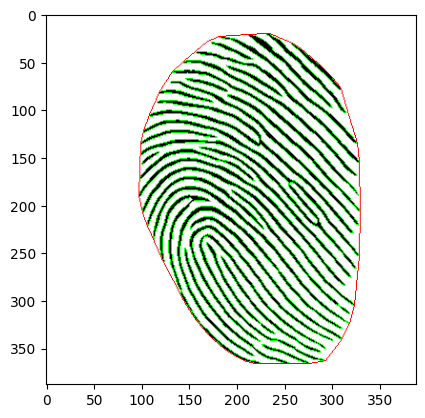

In [13]:
# A compléter
# Calcul du contour convexe à partir des différents contours détectés
all_contours = np.concatenate(list(contours),axis=0)
convex_hull = cv2.convexHull(all_contours)

# Affichage de l'image avec les contours dessinés (vert) et le contour convexe (rouge)
output = cv2.cvtColor(image_example,cv2.COLOR_GRAY2RGB)
cv2.drawContours(output,contours,-1,(0,255,0),1)
cv2.drawContours(output,[convex_hull],-1,(255,0,0),1)
plt.figure()
plt.imshow(output)
plt.show()

A partir de contour convexe, créez un masque, où tous les pixels à l'intérieur du polygone convexe sont blancs et les autres noirs. Pour cela, utilisez la fonction drawContours d'OpenCV, en indiquant l'option pour remplir le contour. Affichez le masque obtenu

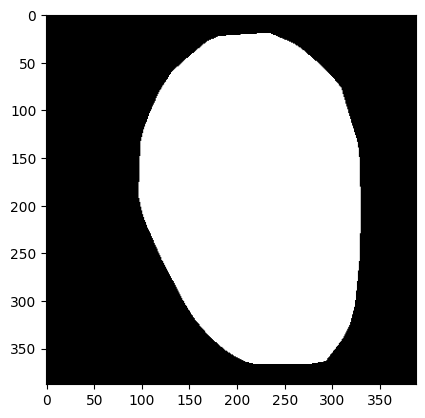

In [14]:
# A compléter
# Création du masque convexe
convex_mask = np.zeros_like(image_example)
cv2.drawContours(convex_mask,[convex_hull],-1,255,-1)

# Affichage du masque convexe
plt.figure()
plt.imshow(convex_mask,'gray')
plt.show()

Ce masque ici définit les pixels considérés comme dans le champ de captation de l'empreinte. On va donc réduire cette zone afin par la suite de filtrer les minutiaes situées sur le bord du champ de captation. Pour cela, effectuez une érosion de ce masque avec un kernel elliptique de taille 15x15. Affichez le masque obtenu

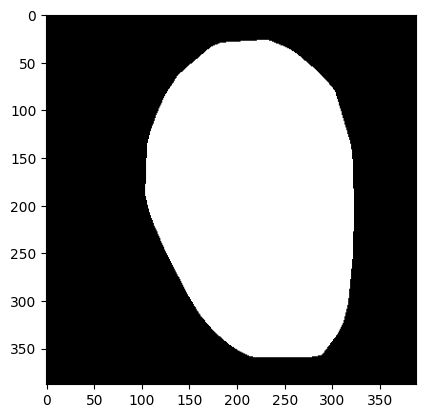

In [15]:
# A compléter
# Erosion du masque convexe
erode_convex_mask = cv2.erode(convex_mask,cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(15,15)))

# Affichage du masque convexe érodé
plt.figure()
plt.imshow(erode_convex_mask,'gray')
plt.show()

Pour finir, filtrez vos terminaisons et bifurcations détectées en ne sélectionnant que ceux inclus dans le masque convexe érodé (via leurs coordonnées cartésiennes). Affichez l'image originale avec les terminaisons et bifurcations filtrées

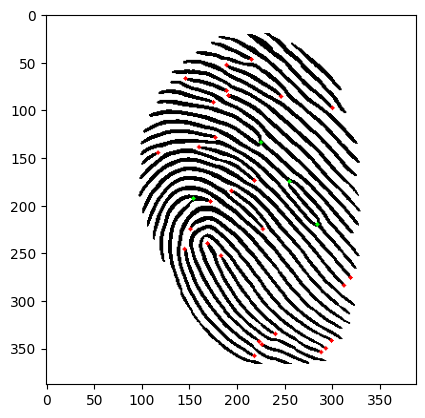

In [16]:
# A compléter
# Filtrage des terminaisons et bifurcations inclus dans le masque convexe érodé
filtered_terms = np.stack([t for t in terms if erode_convex_mask[int(t[0]),int(t[1])]],0)
filtered_bifs = np.stack([b for b in bifs if erode_convex_mask[int(b[0]),int(b[1])]],0)

# Modification (minime) de la fonction d'affichage
def plot_minutiaes(img,terms,bifs):
    output = cv2.cvtColor(img,cv2.COLOR_GRAY2RGB)
    for t in terms:
        cv2.circle(output,(int(t[1]),int(t[0])),2,(255,0,0),-1)
    for b in bifs:
        cv2.circle(output,(int(b[1]),int(b[0])),2,(0,255,0),-1)
    plt.figure()
    plt.imshow(output)
    plt.show()

# Affichage de l'image originale avec les terminaisons et bifurcations filtrées
plot_minutiaes(image_example,filtered_terms,filtered_bifs)

Regroupez tout le code précédent pour faire une fonction de filtrage des minutiaes prenant en entrée l'image originale, les terminaisons et bifurcations détectées et qui retournera les minutiaes filtrées

In [17]:
# A compléter
# Fonction de filtrage des minutiaes
def filter_minutiaes(img, terms, bifs):
    contours,__ = cv2.findContours(~img,cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    all_contours = np.concatenate(list(contours),axis=0)
    convex_hull = cv2.convexHull(all_contours)
    convex_mask = np.zeros_like(img)
    cv2.drawContours(convex_mask,[convex_hull],-1,255,-1)
    erode_convex_mask = cv2.erode(convex_mask,cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(25,25)))
    filtered_terms = np.stack([t for t in terms if erode_convex_mask[int(t[0]),int(t[1])]],0)
    filtered_bifs = np.stack([b for b in bifs if erode_convex_mask[int(b[0]),int(b[1])]],0)
    return filtered_terms, filtered_bifs

h) Voilà tout ! La fonction de détection est opérationnelle ! Implémentez une fonction globale qui détecte toutes les terminaisons à partir de l'image originale et effectue le filtrage pour supprimer les minutiaes en dehors du champ de captation. Calculez ensuite les minutiaes de toutes les images de la base de données *DB_FBI* et stockez les informations dans un dictionnaire (clé : nom du suspect, valeur : terminaisons et bifurcations de l'image calculée). Enfin, affichez quelques images de la base de données avec les minutiaes détectées.

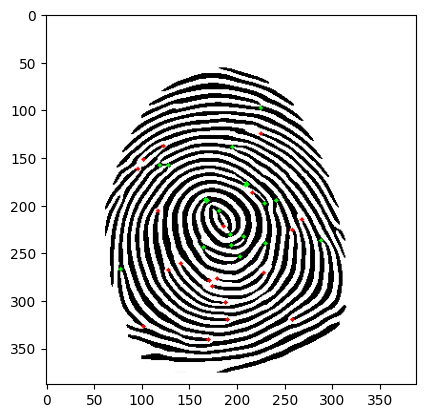

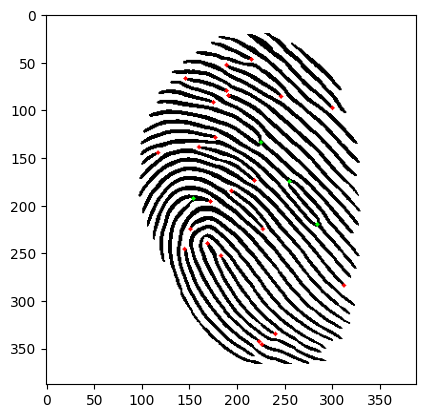

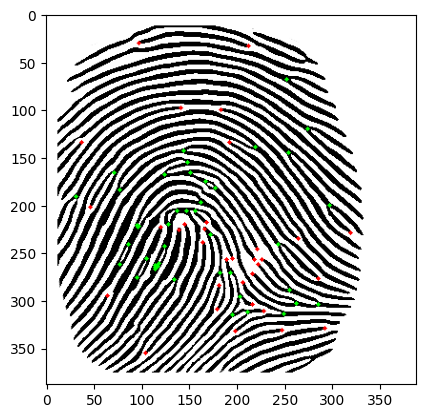

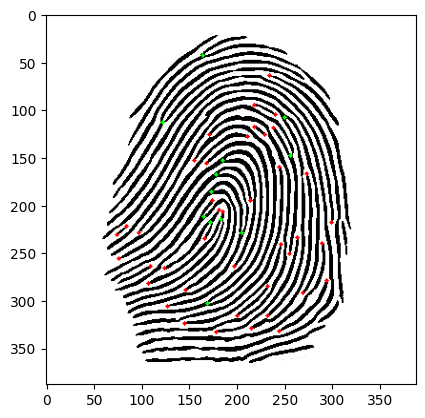

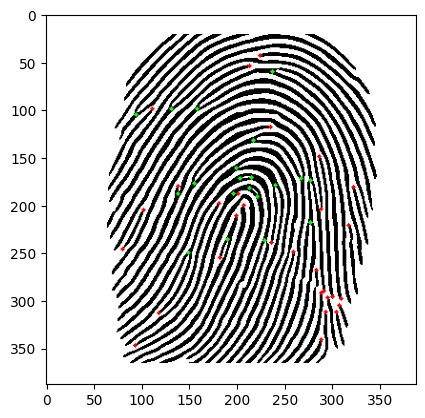

In [18]:
# A compléter
# Fonction globale de détection des minutiaes à partir de l'image originale
def find_minutiaes(img):
    skel_img = skimage.morphology.thin(~img)
    terms, bifs = detect_minutiaes(skel_img)
    terms, bifs = filter_minutiaes(img,terms,bifs)
    return terms,bifs
    
# Calcul des minutiaes sur toutes les images de la base de données et stockage dans un dictionnaire
images = {f.replace('.tif',''):cv2.imread(path+f,0) for f in os.listdir(path)}
all_minutiaes = {name:find_minutiaes(images[name]) for name in images.keys()}

# Affichage de plusieurs images de la base de données avec les minutiaes détectées
for name in ['Ted','Barney','Robin','Lily','Marshall']:
    plot_minutiaes(images[name],all_minutiaes[name][0],all_minutiaes[name][1])

---

## 2) C'est du propre !



Il faut maintenant s'attaquer aux images prélevées sur la scène de crime. Malheureusement, elles ne sont pas d'aussi bonne qualité que les images de la base de données du FBI. Il est donc nécessaire de les pré-traiter.

Chargez et affichez l'image du suspect

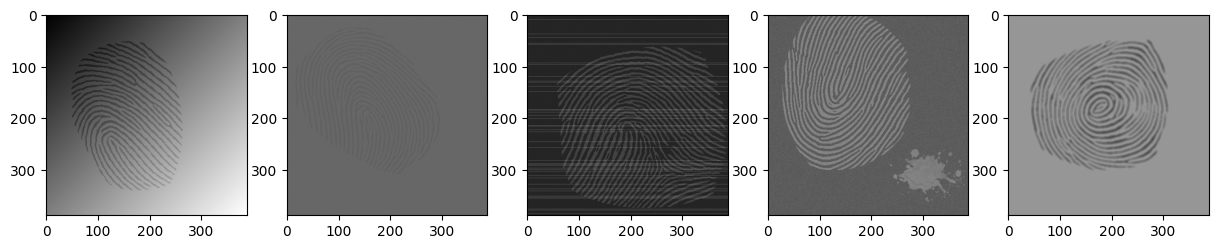

In [19]:
# A compléter
# Chargement de l'image du suspect
path_suspect = 'Images_suspects/'
images_suspects = [cv2.imread(path_suspect+f,0) for f in os.listdir(path_suspect)]

# Affichage de l'image du suspect
plt.figure(figsize=(15,15))
for i,img in enumerate(images_suspects):
    plt.subplot(1,len(images_suspects),i+1)
    plt.imshow(img,'gray',vmin=0,vmax=255)
plt.show()

A vous de prétraiter l'image, pas d'indications ! Pour cela, vous pouvez utiliser ce que vous avez vu en TD et TP précédemment, mais aussi aller chercher d'autres méthodes pouvant répondre à vos problématiques. 

Dans un premier temps, analysez votre image afin d'identifier les problèmes. A travers les problèmes identifiés, proposez votre processus de prétraitement pour résoudre ces problèmes en justifiant vos choix. L'image finale devra être binarisée. Enfin, analysez de manière objective votre processus de prétraitement en précisant les points positifs et points d'amélioration.

*Note : n'hésitez pas à afficher les résultats intermédiaires ! Et surtout, commentez votre code !*

*Note 2 : il est difficile de trouver des méthodes permettant de résoudre vos problèmes si vous ne les connaissez pas. C'est là qu'un outil comme ChatGPT est intéressant. Si vous lui décrivez bien les problèmes de l'image, il peut vous trouver des solutions adaptées. Le plus important est de bien décrire ce que vous constatez. Si je vous précise ça, c'est que je vous autorise, voire conseille de l'utiliser*

***Analyse de l'image et identification des problèmes :***

***Présentation du processus de prétraitement avec justification des choix :***

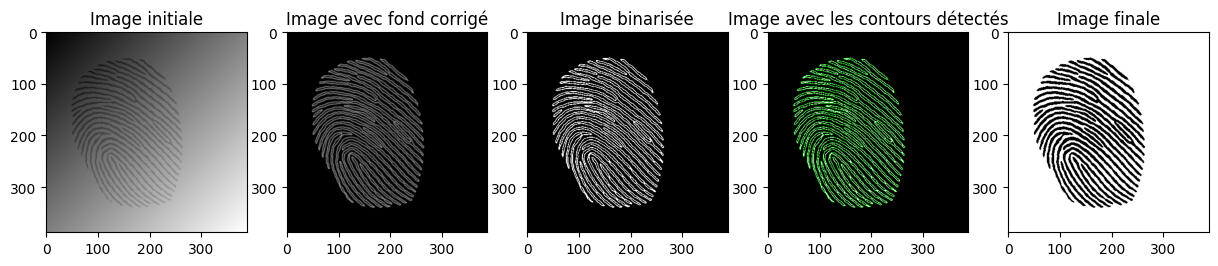

In [20]:
# IMAGE SUSPECT 1
# Implémentation du processus de prétraitement

# Affichage de l'image initiale
plt.figure(figsize=(15,15))
plt.subplot(151)
plt.imshow(images_suspects[0],'gray')
plt.title('Image initiale')

def correct_background(image):
    # Appliquer un flou gaussien pour obtenir une image de fond lissée
    blurred_image = cv2.GaussianBlur(image, (5,5), 0)
    # Soustraire l'image lissée pour corriger le fond
    corrected_image = cv2.absdiff(image, blurred_image)
    # Normaliser l'image corrigée
    corrected_image = cv2.normalize(corrected_image, None, 0, 255, cv2.NORM_MINMAX)
    return corrected_image

# Correction de l'éclairage afin d'avoir un fond uniforme
corrected_image = correct_background(images_suspects[0])
plt.subplot(152)
plt.imshow(corrected_image,'gray')
plt.title('Image avec fond corrigé')

# Binarisation de l'image (on va avoir les contours en surbrillance)
_,bin_image = cv2.threshold(corrected_image,80,255,cv2.THRESH_BINARY)
plt.subplot(153)
plt.imshow(bin_image,'gray')
plt.title('Image binarisée')

# Détection de contours sur l'image binarisée. 
# On va retracer les contours en les remplissant. 
contours,__ = cv2.findContours(bin_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
output = cv2.cvtColor(bin_image,cv2.COLOR_GRAY2RGB)
cv2.drawContours(output,contours,-1,(0,255,0),1)
plt.subplot(154)
plt.imshow(output,'gray')
plt.title('Image avec les contours détectés')

# Recréation de l'image avec les contours détectés remplis
output_1 = np.zeros_like(corrected_image)
cv2.drawContours(output_1,contours,-1,255,-1)

output_1 = ~output_1

# Affichage de l'image prétraitée
plt.subplot(155)
plt.imshow(output_1,'gray')
plt.title('Image finale')
plt.show()

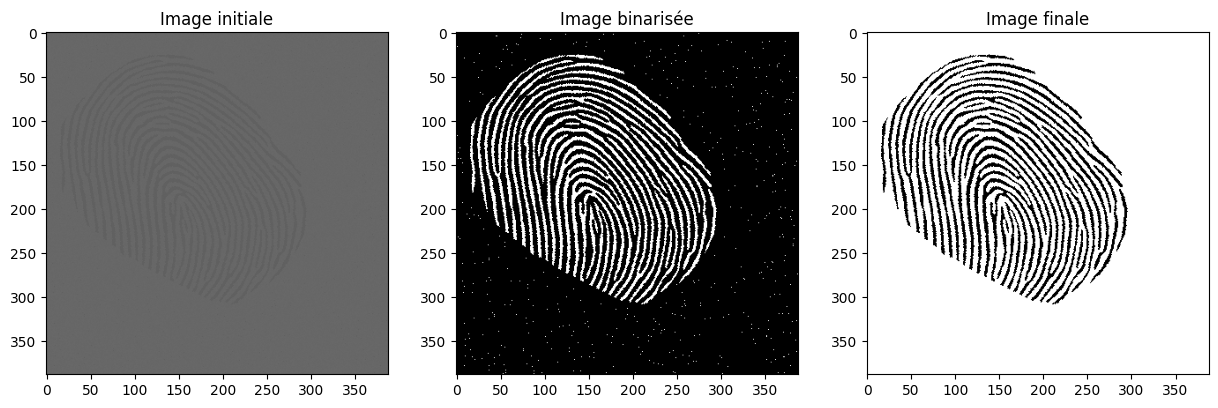

In [21]:
# IMAGE SUSPECT 2
# Implémentation du processus de prétraitement

# Affichage de l'image initiale
plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(images_suspects[1],'gray',vmin=0,vmax=255)
plt.title('Image initiale')

# Binarisation avec le seuil précis de 100. En effet, l'image a très très peu de contraste, mais au final, elle est assez uniforme.
# Avec ce seuil précis, on retrouve directement l'empreinte, avec un peu de bruit.
# Une étape préliminaire aurait pu être d'augmenter le contraste en manipulant l'histogramme de l'image.
__,bin_image = cv2.threshold(images_suspects[1],100,255,cv2.THRESH_BINARY_INV)
plt.subplot(132)
plt.imshow(bin_image,'gray')
plt.title('Image binarisée')

# Détection de contours et élimination des contours trop petits (bruit)
contours,__ = cv2.findContours(bin_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contours = [c for c in contours if cv2.contourArea(c)>10]

# Recréation de l'image avec les contours détectés remplis
output_2 = np.zeros_like(bin_image)
cv2.drawContours(output_2,contours,-1,255,-1)

output_2 = ~output_2

plt.subplot(133)
plt.imshow(output_2,'gray')
plt.title('Image finale')
plt.show()

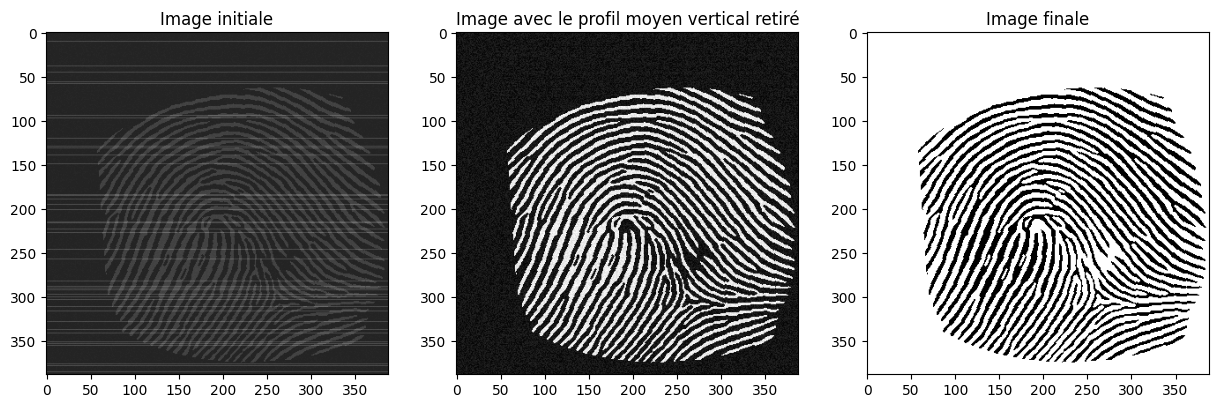

In [22]:
# IMAGE SUSPECT 3
# Implémentation du processus de prétraitement

# Affichage de l'image initiale
plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(images_suspects[2],'gray',vmin=0,vmax=255)
plt.title('Image initiale')

# Calcul du profile de l'image dans l'axe vertical
# On prend les 50 premières colonnes et on calcule la moyenne de ces colonnes pour obtenir un vecteur.
# Le vecteur donne les valeurs moyennes de chaque lignes sur le fond noir.
profile_x = np.mean(images_suspects[2][:,:50],axis=1)

# On soustrait à chaque colonne de l'image le profil. On obtient alors une image où les lignes sont retirées
corrected_image = images_suspects[2] - np.repeat(np.expand_dims(profile_x,axis=1),388,axis=1)

# Normalisation de l'image entre 0 et 255
norm_image = ((corrected_image-corrected_image.min())/(corrected_image.max()-corrected_image.min())*255).astype(np.uint8)

plt.subplot(132)
plt.imshow(corrected_image,'gray')
plt.title('Image avec le profil moyen vertical retiré')

# Binarisation de l'image
_,output_3 = cv2.threshold(norm_image,100,255,cv2.THRESH_BINARY_INV)

plt.subplot(133)
plt.imshow(output_3,'gray')
plt.title('Image finale')

plt.show()

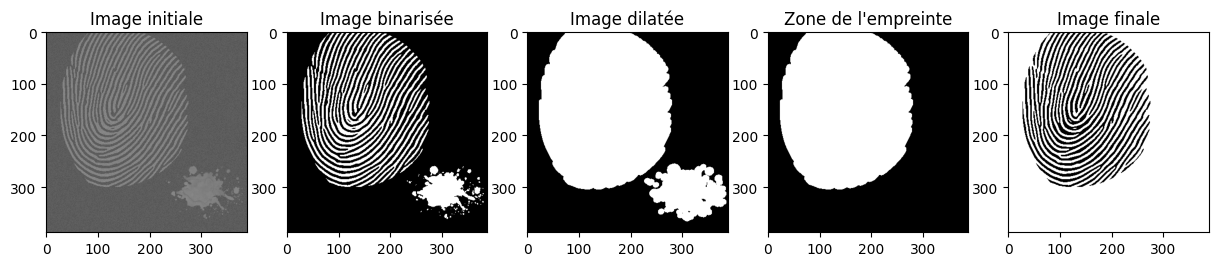

In [23]:
# IMAGE SUSPECT 4
# Implémentation du processus de prétraitement

# Affichage de l'image initiale
plt.figure(figsize=(15,15))
plt.subplot(151)
plt.imshow(images_suspects[3],'gray',vmin=0,vmax=255)
plt.title('Image initiale')

# Binarisation de l'image pour mettre en valeur l'empreinte (et la tâche malheureusement)
_,bin_image = cv2.threshold(images_suspects[3],100,255,cv2.THRESH_BINARY)
plt.subplot(152)
plt.imshow(bin_image,'gray',vmin=0,vmax=255)
plt.title('Image binarisée')

# Grosse diatation de l'image. L'objectif est de relier les sillons de l'empreinte d'une part, et la tâche d'une autre part. 
# Ca nous fait plusieurs "zones" qu'on pourra ensuite traiter
dilate_image = cv2.morphologyEx(bin_image,cv2.MORPH_DILATE,cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(11,11)))
plt.subplot(153)
plt.imshow(dilate_image,'gray',vmin=0,vmax=255)
plt.title('Image dilatée')

# Détection des contours sur l'image dilatée, et filtrage des contours pour ne garder que le plus gros
contours,__ = cv2.findContours(dilate_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
contours = [cnt for cnt in contours if cv2.contourArea(cnt)>50000]

# Création du masque indiquant la zone de l'empreinte (à partir du contour restant)
fingerprint_zone_mask = np.zeros_like(bin_image)
cv2.drawContours(fingerprint_zone_mask,contours,-1,255,-1)
plt.subplot(154)
plt.imshow(fingerprint_zone_mask,'gray',vmin=0,vmax=255)
plt.title("Zone de l'empreinte")

# Calcul du masque final avec un AND logique entre l'image binarisée et la zone de l'empreinte
output_4 = ~(np.logical_and(bin_image, fingerprint_zone_mask)*255).astype(np.uint8)
plt.subplot(155)
plt.imshow(output_4,'gray')
plt.title("Image finale")
plt.show()

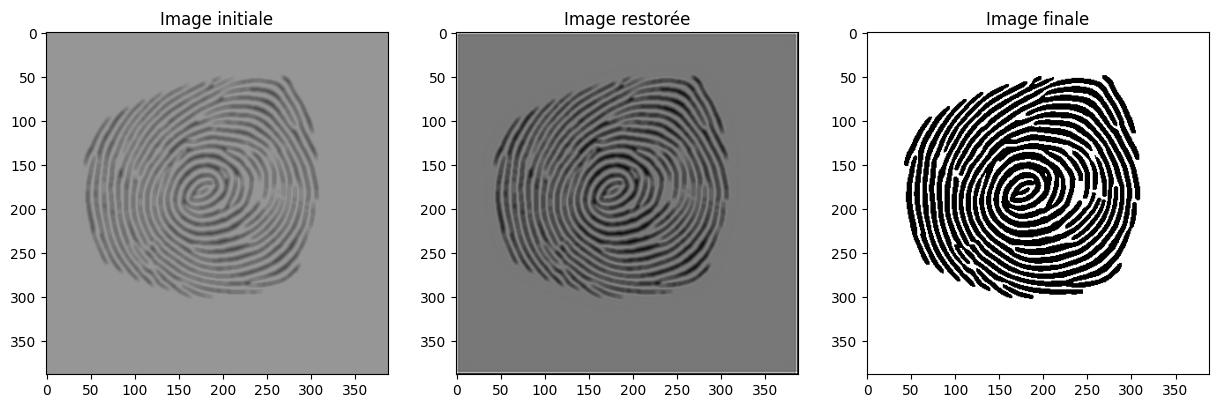

In [24]:
from scipy.signal import convolve2d

def richardson_lucy_deconvolution(image, psf, iterations=10):
    """
    Applique la déconvolution de Richardson-Lucy à une image floue.

    :param image: Image floue en niveaux de gris (numpy array).
    :param psf: Point Spread Function (PSF), ou noyau de flou (numpy array).
    :param iterations: Nombre d'itérations de l'algorithme.
    :return: Image restaurée après déconvolution.
    """
    image = image.astype(np.float32)
    psf = psf.astype(np.float32)
    
    estimate = np.full(image.shape, 0.5, dtype=np.float32)  # Initialisation de l'image estimée

    psf_mirror = psf[::-1, ::-1]  # PSF retournée (utilisée pour la convolution)

    for _ in range(iterations):
        relative_blur = convolve2d(estimate, psf, 'same')
        relative_blur[relative_blur == 0] = 1e-10  # Éviter la division par zéro

        estimate *= convolve2d(image / relative_blur, psf_mirror, 'same')

    return np.clip(estimate, 0, 255).astype(np.uint8)

# IMAGE SUSPECT 4
# Implémentation du processus de prétraitement

# Affichage de l'image initiale
plt.figure(figsize=(15,15))
plt.subplot(131)
plt.imshow(images_suspects[4],'gray',vmin=0,vmax=255)
plt.title('Image initiale')

# Noyau de flou (par exemple, un noyau gaussien)
psf_size = 5
psf = cv2.getGaussianKernel(psf_size, 1)
psf = np.outer(psf, psf)

restored_image = richardson_lucy_deconvolution(images_suspects[4], psf, iterations=5)
plt.subplot(132)
plt.imshow(restored_image,'gray')
plt.title('Image restorée')

_,output_5 = cv2.threshold(restored_image,140,255,cv2.THRESH_BINARY)

output_5[:5,:]=255
output_5[-5:,:]=255
output_5[:,:5]=255
output_5[:,-5:]=255

plt.subplot(133)
plt.imshow(output_5,'gray')
plt.title('Image finale')
plt.show()

***Analyse de votre processus de prétraitement :***

Détectez maintenant les minutiaes avec votre image suspect prétraitée, et affichez le résultat.

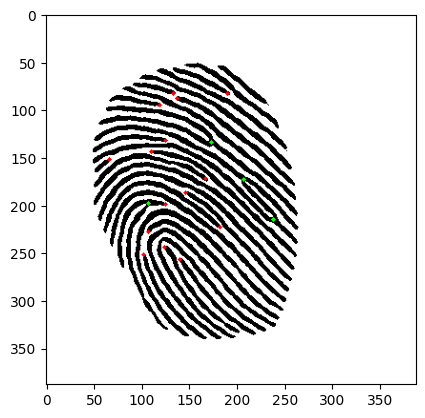

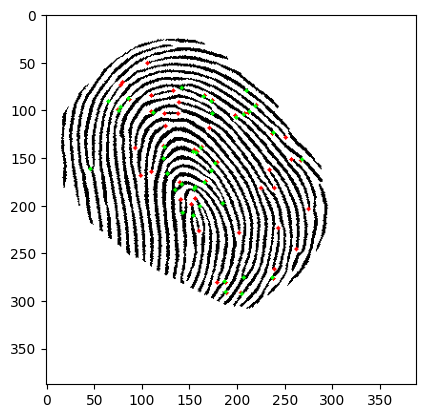

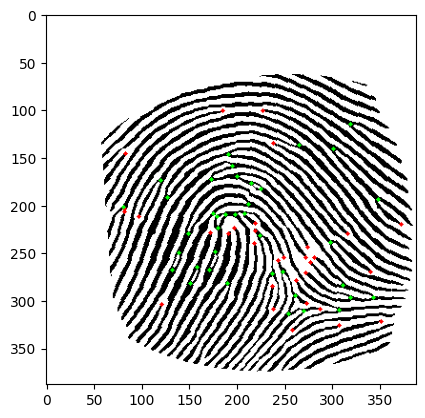

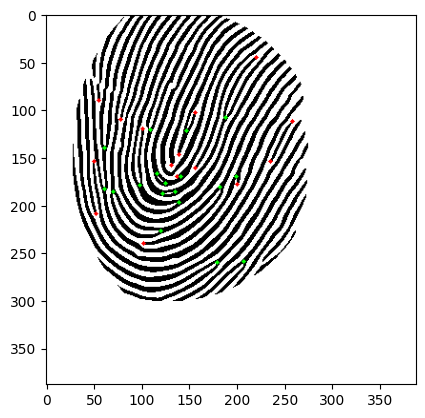

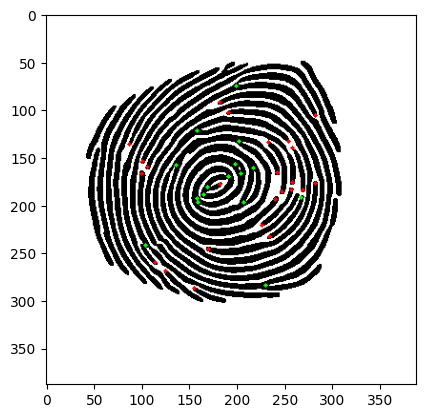

In [25]:
# A compléter
# Détection des minutiaes sur l'image suspect
corrected_images = {'suspect 1':output_1,
                    'suspect 2':output_2,
                    'suspect 3':output_3,
                    'suspect 4':output_4,
                    'suspect 5':output_5}

suspect_minutiaes = {name:find_minutiaes(corrected_images[name]) for name in corrected_images.keys()}

# Affichage de l'image suspect originale avec les minutiaes détectées
for name in corrected_images.keys():
    plot_minutiaes(corrected_images[name],suspect_minutiaes[name][0],suspect_minutiaes[name][1])

***Le résultat est-il satisfaisant ?***

***Réponse :***

---

## 3) Ca matche ou ça casse

Vous avez détecté les minutiaes des empreintes, il est l'heure maintenant d'identifier les malfrats. Pour se faire, on va comparer les caractéristiques des empreintes révélées sur la scène de crime avec celles de la base de données. Cette étape n'est pas facile : on a des nuages de points qui dépendent beaucoup de la qualité des traitements précédents. De plus, les empreintes récoltées ne sont pas de même taille, dans la même direction, ni positionnées au même endroit dans l'image. Bref, c'est la galère.

Heureusement, je vous fournis un code, permettant de faire ce matching :

In [26]:
import numpy as np
from itertools import product
from scipy.optimize import linear_sum_assignment

def center_points_on_index(M, i, angle_index):
    """
    Centre les points de la matrice M autour du point d'indice i, en tenant compte de l'angle.

    Args:
        M (np.ndarray): Matrice de points de taille Nx3 avec x, y et angle.
        i (int): Indice du point autour duquel centrer.
        angle_index (int): Indice de l'angle à utiliser pour la rotation.

    Returns:
        np.ndarray: Matrice centrée avec les points ajustés.
    """
    angle_i = M[i, 2 + angle_index]  # Angle du point d'indice i

    # Matrice de rotation basée sur l'angle
    R = np.array([[np.cos(angle_i), np.sin(angle_i)],
                  [-np.sin(angle_i), np.cos(angle_i)]])
    
    B = np.zeros_like(M)  # Matrice pour les points centrés et ajustés
    B[:, :2] = np.dot(M[:, :2] - M[i, :2], R.T)  # Appliquer la rotation et centrer
    B[:, 2:] = np.sort((M[:, 2:] - angle_i) % (2 * np.pi), axis=1)  # Ajuster les angles

    return B

def rotate_points(M, alpha):
    """
    Applique une rotation d'angle alpha aux points de la matrice M.

    Args:
        M (np.ndarray): Matrice de points de taille Nx3 avec x, y et angle.
        alpha (float): Angle de rotation en radians.

    Returns:
        np.ndarray: Matrice des points après rotation.
    """
    # Matrice de rotation basée sur l'angle alpha
    R = np.array([[np.cos(alpha), -np.sin(alpha)],
                  [np.sin(alpha), np.cos(alpha)]])
    
    B = np.zeros_like(M)  # Matrice pour les points après rotation
    B[:, :2] = np.dot(M[:, :2], R.T)  # Appliquer la rotation
    B[:, 2:] = M[:, 2:] + alpha  # Ajuster les angles

    return B

def score(T1, T2, w_cartesian=1.0, w_angular=1.0, w_dif=1.0):
    """
    Calcule la matrice de coût basée sur les distances cartésiennes et angulaires entre deux ensembles de points.

    Args:
        T1 (np.ndarray): Premier ensemble de points Nx3 (terminaisons) ou Nx5 (bifurcations).
        T2 (np.ndarray): Deuxième ensemble de points Mx3 (terminaisons) ou Mx5 (bifurcations).
        w_cartesian (float): Poids pour la distance cartésienne.
        w_angular (float): Poids pour la distance angulaire.
        w_dif (float): Poids pour les points sans correspondance.
    Returns:
        tuple: Coût moyen des correspondances et les indices des correspondances optimales (row_ind, col_ind).
    """

    # On inverse l'ordre des matrices si besoin afin qu'il y ait autant ou plus de points dans T1 que dans T2
    if T1.shape[0] < T2.shape[0]:
        tmp = T1.copy()
        T1 = T2.copy()
        T2 = tmp
        reverse_result=True
    else:
        reverse_result=False
    # Distance cartésienne entre les points   
    T1x = T1[:, 0].reshape(-1, 1)
    T1y = T1[:, 1].reshape(-1, 1)
    T2x = T2[:, 0]
    T2y = T2[:, 1]
    dx = T1x - T2x
    dy = T1y - T2y
    cartesian_distance = np.sqrt(dx**2 + dy**2)  # Distance euclidienne

    # Distance angulaire entre les orientations des points
    angular_distance = np.zeros_like(cartesian_distance)
    for i in range(T1.shape[1] - 2):
        T1theta = T1[:, 2 + i].reshape(-1, 1)
        T2theta = T2[:, 2 + i]
        diff = np.abs(T1theta - T2theta) % (2 * np.pi)
        angular_distance += np.minimum(diff, 2 * np.pi - diff)  # Différence minimale en considérant la périodicité

    # Calcul de la matrice de coût
    cost_matrix = w_cartesian * cartesian_distance + w_angular * angular_distance

    # Ajout de la possibilité de non match en étendant cost_matrix
    no_match_cost_matrix = np.ones_like(cost_matrix)*w_dif
    cost_matrix = np.concatenate([cost_matrix,no_match_cost_matrix],axis=1)


    # Algorithme de Hongrie pour trouver le meilleur appariement
    row_ind, col_ind = linear_sum_assignment(cost_matrix)

    # Coût moyen des correspondances
    mean_cost = cost_matrix[row_ind, col_ind].mean()
    col_ind[col_ind>=T2.shape[0]]=-1
    if reverse_result:
        return mean_cost, col_ind, row_ind
    else:
        return mean_cost, row_ind, col_ind


def match(M1, M2, w_cartesian=1.0, w_angular=1.0, w_dif=20.0):
    """
    Trouve le meilleur appariement entre deux ensembles de points en minimisant le coût.

    Args:
        M1 (np.ndarray): Premier ensemble de points de taille Nx3 (terminaisons) ou Nx5 (bifurcations).
        M2 (np.ndarray): Deuxième ensemble de points Mx3 (terminaisons) ou Mx5 (bifurcations).
        w_cartesian (float): Poids pour la distance cartésienne.
        w_angular (float): Poids pour la distance angulaire.
        w_dif (float): Poids pour les points sans correspondance.

    Returns:
        tuple: Coût minimal trouvé pour l'appariement et les correspondances optimales.
    """
    count1 = M1.shape[0]
    count2 = M2.shape[0]
    nb_angles = M1.shape[1] - 2

    if count1 > 0 and count2 > 0:
        # Centrage et ajustement des points
        T1 = np.array([center_points_on_index(M1, i, j) for i, j in product(range(count1), range(nb_angles))])
        T2 = np.array([center_points_on_index(M2, i, j) for i, j in product(range(count2), range(nb_angles))])
        
        # Initialisation des variables pour le coût minimal et les correspondances optimales
        min_cost = float('inf')
        best_row_ind = None
        best_col_ind = None

        # Calcul du coût minimal entre toutes les paires de points centrés et ajustés
        for i, j in product(range(T1.shape[0]), range(T2.shape[0])):
            cost, row_ind, col_ind = score(T1[i], T2[j], w_cartesian, w_angular, w_dif)
            if cost < min_cost:
                min_cost = cost
                best_row_ind = row_ind
                best_col_ind = col_ind
        
        return min_cost, best_row_ind, best_col_ind
    else:
        # Si l'un des ensembles est vide, le coût est basé sur la différence de taille des ensembles
        return w_dif * (count1 + count2), None, None

Le code précédent va tenter de faire correspondre au mieux les terminaisons ou bifurcations de deux empreintes. Ces correspondances vont se faire en essayant de répondre au mieux aux conditions suivantes :
- La distance entre les points matchés doit être le plus faible possible
- La distance angulaire des orientations des terminaisons et bifurcations doit être la plus faible possible

A l'issue de cette estimation, on va calculer un score de match indiquant la qualité des correspondances effectuées. Plus le score est faible, plus les empreintes sont proches, et inversement. 

Vous pouvez pondérer le score avec 3 facteurs à votre disposition :
- w_cartesian : le poids de la distance cartésienne entre les correspondances
- w_angular : le poids de la distance angulaire entre les orientations des correspondances
- w_dif : le poids des points sans correspondance

Plus un facteur est gros par rapport aux autres, plus son influence modifiera le score est ainsi les correspondances effectuées.

Cet appariement peut être assez long, donc j'ai optimisé au maximum le code pour éviter que vous attendiez les résultats pendant une demi-heure. Complétez le code suivant en fonction des indications pour pouvoir ensuite faire le matching.

In [27]:
# A compléter
import concurrent
import progressbar

id = 'suspect 5'

image_suspect = corrected_images[id]
terminaisons_suspect = suspect_minutiaes[id][0] # Terminaisons de l'empreinte du suspect (Tableau Nx3)
biffucartions_suspect = suspect_minutiaes[id][1] # Bifurcations de l'empreinte du suspect (Tableau Mx5)

nom_suspects = images.keys() # Liste des noms des suspects


terminaisons_FBI = {name:all_minutiaes[name][0] for name in nom_suspects} # Terminaisons des empreintes de la base de données du FBI (Dictionnaire de tableaux Nx3 avec nom des suspects en clé)
bifucartions_FBI = {name:all_minutiaes[name][1] for name in nom_suspects} # Bifurcations des empreintes de la base de données du FBI (Dictionnaire de tableaux Mx5 avec nom des suspects en clé)

def compute_score(params):
    k, terms, biffs, terms2, biffs2 = params
    score_terms, row_ind_terms, col_ind_terms = match(terms, terms2)
    score_biffs, row_ind_biffs, col_ind_biffs = match(biffs, biffs2)
    return {
        'id':k,
        'score':score_terms+score_biffs,
        'terms_match':np.stack([row_ind_terms,col_ind_terms]),
        'biffs_match':np.stack([row_ind_biffs,col_ind_biffs])
    }


# Création de la barre de progression
progress = progressbar.ProgressBar(max_value=len(terminaisons_FBI.keys()))

matching_result = {}

# Utilisation de ThreadPoolExecutor pour paralléliser le calcul des scores
with concurrent.futures.ThreadPoolExecutor() as executor:
    params = {k:(k,terminaisons_FBI[k],bifucartions_FBI[k],terminaisons_suspect,biffucartions_suspect) for k in nom_suspects}
    future_to_key = {executor.submit(compute_score, params[k]): k for k in nom_suspects}
    
    for future in progress(concurrent.futures.as_completed(future_to_key)):
        res = future.result()
        matching_result[res['id']] = res

  0% (0 of 20) |                         | Elapsed Time: 0:00:00 ETA:  --:--:--
  5% (1 of 20) |#                        | Elapsed Time: 0:00:00 ETA:   0:00:11
 10% (2 of 20) |##                       | Elapsed Time: 0:00:00 ETA:   0:00:08
 15% (3 of 20) |###                      | Elapsed Time: 0:00:01 ETA:   0:00:07
 20% (4 of 20) |#####                    | Elapsed Time: 0:00:01 ETA:   0:00:06
 30% (6 of 20) |#######                  | Elapsed Time: 0:00:02 ETA:   0:00:05
 35% (7 of 20) |########                 | Elapsed Time: 0:00:02 ETA:   0:00:04
 40% (8 of 20) |##########               | Elapsed Time: 0:00:02 ETA:   0:00:04
 45% (9 of 20) |###########              | Elapsed Time: 0:00:02 ETA:   0:00:03
 55% (11 of 20) |#############           | Elapsed Time: 0:00:03 ETA:   0:00:02
 60% (12 of 20) |##############          | Elapsed Time: 0:00:03 ETA:   0:00:02
 65% (13 of 20) |###############         | Elapsed Time: 0:00:05 ETA:   0:00:03
 70% (14 of 20) |################       

In [28]:
print("Résultat de matching : ")
min_matching_name = ''
min_score = np.inf
for name in nom_suspects:
    score_match=matching_result[name]['score']
    print('{} : {}'.format(name,score_match))
    if score_match<min_score:
        min_score=score_match
        min_matching_name=name

print("Suspect le plus probable : {}".format(min_matching_name))

Résultat de matching : 
Barney : 29.59953283313954
Chandler : 35.926676992306085
Dwight : 28.19881621714447
Howard : 35.221226484271156
Joey : 33.06553339042806
John : 39.6638210278554
Leonard : 31.70078495643538
Lily : 30.28560955047527
Marshall : 30.71381918861804
Michael : 32.4271183537792
Monica : 31.184460497033342
Pam : 34.92648991326691
Penny : 35.02006706119383
Phoebe : 36.018018820416124
Rachel : 39.88544744168941
Rajesh : 34.115176552266306
Robin : 32.659916944728394
Ross : 35.78080912732722
Sheldon : 34.100502752191986
Ted : 18.863733881734735
Suspect le plus probable : Ted


Vous avez ci-dessous une fonction qui affiche les correspondances de terminaisons et bifurcations trouvées entre 2 images.

In [29]:
import cv2
from matplotlib import pyplot as plt

def plot_matching(img1, img2, terms1, terms2, biffs1, biffs2, terms_match, biffs_match):
    """
    Affiche les correspondances entre deux images en utilisant des points d'intérêt (termes et bifurcations).

    Args:
        img1 (np.ndarray): Première image en niveaux de gris.
        img2 (np.ndarray): Deuxième image en niveaux de gris.
        terms1 (np.ndarray): Points d'intérêt (terminaisons) de la première image, de taille Nx2.
        terms2 (np.ndarray): Points d'intérêt (terminaisons) de la deuxième image, de taille Mx2.
        biffs1 (np.ndarray): Points d'intérêt (bifurcations) de la première image, de taille Px2.
        biffs2 (np.ndarray): Points d'intérêt (bifurcations) de la deuxième image, de taille Qx2.
        terms_match (np.ndarray): Correspondances entre les terminasons des deux images, de taille 2xK.
        biffs_match (np.ndarray): Correspondances entre les bifurcations des deux images, de taille 2xL.

    Returns:
        None: Affiche les images fusionnées avec les correspondances marquées.
    """

    # Récupération des dimensions de la première image
    h, w = img1.shape

    # Fusion des deux images côte à côte et conversion en couleur
    fused_img = cv2.cvtColor(np.concatenate([img1, img2], axis=1), cv2.COLOR_GRAY2RGB)

    # Affichage des points d'intérêt (terminaisons) de la première image en rouge
    if terms1 is not None:
        for t in terms1:
            cv2.circle(fused_img, (int(t[1]), int(t[0])), 2, (255, 0, 0), -1)

    # Affichage des points d'intérêt (bifurcations) de la première image en vert
    if biffs1 is not None:
        for b in biffs1:
            cv2.circle(fused_img, (int(b[1]), int(b[0])), 2, (0, 255, 0), -1)

    # Affichage des points d'intérêt (terminaisons) de la deuxième image en rouge
    if terms2 is not None:
        for t in terms2:
            cv2.circle(fused_img, (int(t[1]) + w, int(t[0])), 2, (255, 0, 0), -1)

    # Affichage des points d'intérêt (bifurcations) de la deuxième image en vert
    if biffs2 is not None:
        for b in biffs2:
            cv2.circle(fused_img, (int(b[1]) + w, int(b[0])), 2, (0, 255, 0), -1)

    # Affichage des lignes de correspondances pour les terminaisons en bleu
    if terms_match is not None:
        for i in range(terms_match.shape[1]):
            j, k = terms_match[:, i]
            if j!=-1 and k!=-1:
                cv2.line(fused_img, (int(terms1[j, 1]), int(terms1[j, 0])), (int(terms2[k, 1]) + w, int(terms2[k, 0])), (0, 0, 255), 1)

    # Affichage des lignes de correspondances pour les bifurcations en jaune
    if biffs_match is not None:
        for i in range(biffs_match.shape[1]):
            j, k = biffs_match[:, i]
            if j!=-1 and k!=-1:
                cv2.line(fused_img, (int(biffs1[j, 1]), int(biffs1[j, 0])), (int(biffs2[k, 1]) + w, int(biffs2[k, 0])), (255, 255, 0), 1)

    # Affichage de l'image avec les correspondances tracées
    plt.figure(figsize=(10, 5))
    plt.imshow(fused_img)
    plt.show()


Utilisez cette fonction pour afficher les correspondances trouvées entre votre image du coupable et celle du suspect le plus probable de votre base de données.

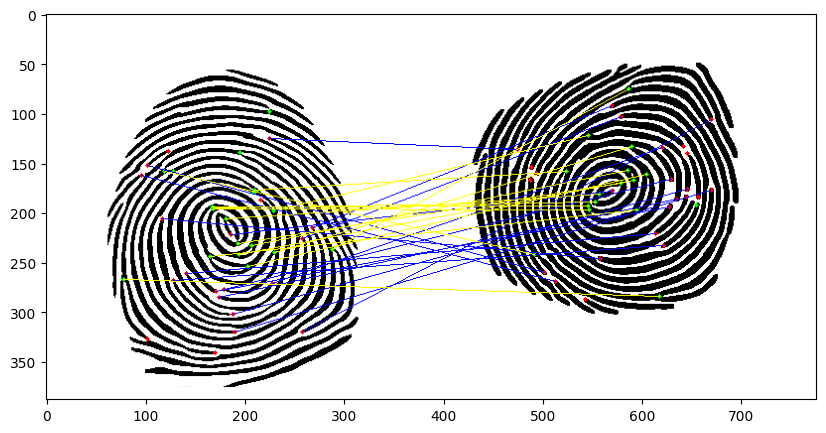

In [30]:
# A compléter
# Affichage des correspondances entre les 2 images
plot_matching(images[min_matching_name],image_suspect,
              terminaisons_FBI[min_matching_name],terminaisons_suspect,
              bifucartions_FBI[min_matching_name],biffucartions_suspect,
              matching_result[min_matching_name]['terms_match'],matching_result[min_matching_name]['biffs_match'])

***Est-ce que ce résultat de correspondances vous paraît satisfaisant ?***

***Réponse :***

***Qui est donc le coupable selon vous ?***

***Réponse :***

- Suspect 1 : Barney
- Suspect 2 : Lily
- Suspect 3 : Robin
- Suspect 4 : Marshall
- Suspect 5 : Ted

---

***Compte-rendu du lieutenant Peralta***

*"Nous avons interrogé des témoins qui étaient sur la scène de crime au moment des faits. Il se trouve que les 5 individus, âgés entre 20 et 30 ans, dinaient dans le restaurant Carmichaels à l'angle de la 5ème avenue et de la 36ème rue Ouest dans Manhattan. Rien n'est à signalé durant le diner, malgré que l'un d'entre eux a dragué assez lourdement la serveuse. C'est après avoir payé l'addition que l'un des individus a volé le cor de chasse bleu accroché au mur du restaurant. Les motivations qui ont menés à ce vol restent encore inconnus à ce jour."*